In [134]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import scipy.stats as stat
#from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression

In [135]:
distorts = [
            lambda eta: eta, 
#             lambda eta:0.3+0.4*eta,
            lambda eta:stat.beta.cdf(eta,0.2,0.2),
            lambda eta:stat.beta.cdf(eta,5.,5.),
            lambda eta:stat.beta.cdf(eta,0.5,2),
            lambda eta:stat.beta.cdf(eta,2,0.5),
            lambda eta:stat.beta.cdf(eta,20,80)*0.25 +
                       stat.beta.cdf(eta,80,20)*0.25 + 
                       stat.beta.cdf(eta,0.1,0.1)*0.5,
            lambda eta:stat.beta.cdf(eta,30,10)*0.5 +
                       stat.beta.cdf(eta,0.1,0.1)*0.5
           ]

num_annots = len(distorts)



In [136]:
def accuracy_score(Y, Y_pred):
    loss = 0.0
    #print(Y.shape[0])
    for i in range(Y.shape[0]):
        loss = loss + ((Y[i]- Y_pred[i])**2)
    return loss/(Y.shape[0])
        
def sort(A,A_sum,labellers):
    for i in range(labellers):
        for j in range(len(A[i])):
            min_index = j
            for k in range(j,len(A[i])):
                if(A_sum[k] < A_sum[min_index]):
                    min_index = k
            A[i][j],A[i][min_index] =  A[i][min_index],A[i][j]
                    
def project(a,b,c):     #a is target, b and c are points on the line
    """ Projection of point 'a' on to the line joining the points 'b' and 'c' """
    v = a - b 
    #print(v)
    d = (c-b)/np.linalg.norm(c-b)
    #print(np.linalg.norm(d))
    #print(d)
    res = b + (np.dot(v,d))*d
    return res

In [137]:
def logisticReg():
    clf_list = []
    accuracy_list = []
    for i in range(X_train_d.shape[0]):
        #Y_train_d[i] =Y_train_d[i].astype('int')
        #Y_test_d[i] =Y_test_d[i].astype('int')
        clf = LogisticRegression(solver='lbfgs').fit(X_train_d[i], Y_train_d[i])
        Y_pred = clf.predict_proba(X_test_d[i])[:,1]
        #print(Y_pred)
        accuracy_list.append(accuracy_score(Y_test_d[i],Y_pred))
    return accuracy_list

In [138]:
def jointLogisticReg():
    loss_list = []
    X_train_full = X_train_d[0]
    Y_train_full = Y_train_d[0]
    for i in range(num_annots):
        X_train_full = np.concatenate((X_train_full, X_train_d[i]))
        Y_train_full = np.concatenate((Y_train_full, Y_train_d[i]))
    clf = LogisticRegression(solver = 'lbfgs').fit(X_train_full,Y_train_full)
    for i in range(num_annots):
        Y_pred = clf.predict_proba(X_test_d[i])[:,1]
        loss_list.append(accuracy_score(Y_test_d[i],Y_pred))
    return loss_list

In [139]:
def isotonicPostProcess():
    clf_list = []
    accuracy_list = []
    for i in range(X_train_d.shape[0]):
        clf = LogisticRegression(solver='lbfgs').fit(X_train_d[i], Y_train_d[i])
        Y_pred_temp_vali = clf.predict_proba(X_valid_d[i])[:,1]
        Y_pred_temp = clf.predict_proba(X_test_d[i])[:,1]
        isoreg_i = IsotonicRegression(out_of_bounds='clip').fit(Y_pred_temp_vali, Y_valid_d[i])
        Y_pred = isoreg_i.predict(Y_pred_temp)
        accuracy_list.append(accuracy_score(Y_test_d[i],Y_pred))
    return accuracy_list

In [140]:
print(isotonicPostProcess())

[0.17435353782902696, 0.23313119385784295, 0.16364242611073335, 0.1717934357094741, 0.17152537180855285, 0.22383537766511513, 0.21091412672178553]


In [141]:
def separateRanking():
    Z_train = list(range(num_annots))
    Z_train_label = list(range(num_annots))
    for i in range(num_annots):
        temp = []
        temp_label = []
        for j in range(len(X_train_d[i])):
            for k in range(j+1,len(X_train_d[i])):
                if(Y_train_d[i][j] != Y_train_d[i][k]):
                    temp.append(X_train_d[i][j]-X_train_d[i][k] )
                    temp_label.append((Y_train_d[i][j]- Y_train_d[i][k]+1)//2)
        Z_train[i] = np.array(temp)
        Z_train_label[i] = np.array(temp_label)

    sr_clf_list = []
    sr_accuracy_list = []
    for i in range(num_annots):
        #Z_train_label[i] =Z_train_label[i].astype('int')
        #Y_test_d[i] =Y_test_d[i].astype('int')
        clf = LogisticRegression(solver='lbfgs').fit(Z_train[i], Z_train_label[i])
        sr_clf_list.append(clf)

    sr_probab = list(range(num_annots))
    iso_reg = list(range(num_annots))
    for i in range(num_annots):
        sr_probab[i] = (sr_clf_list[i].predict_proba(X_train_d[i]))[:,1]
        iso_reg[i] = IsotonicRegression(out_of_bounds = 'clip').fit(sr_probab[i],Y_train_d[i])

    Y_pred_sr = list(range(num_annots))
    sr_accuracy_list = list(range(num_annots))
    for i in range(num_annots):
        temp=  iso_reg[i].predict((sr_clf_list[i].predict_proba(X_test_d[i]))[:,1])
        #print(max(temp))
        sr_accuracy_list[i] = accuracy_score(Y_test_d[i],np.array(temp))
    return sr_accuracy_list


In [142]:
#Joint Ranking 
def jointRanking():
    Z_train = []
    Z_train_label = []
    temp  = []
    temp_label = []
    for i in range(num_annots):
        for j in range(len(X_train_d[i])):
            for k in range(j+1,len(X_train_d[i])):
                if(Y_train_d[i][j] != Y_train_d[i][k]):
                    temp.append(X_train_d[i][j]-X_train_d[i][k] )
                    temp_label.append((Y_train_d[i][j]- Y_train_d[i][k] + 1)//2)
    Z_train = np.array(temp)
    Z_train_label = np.array(temp_label)
    
    #Logistic Regression separately for each labeller on the transformed data
    jr_clf = 0
    jr_accuracy = 0
    #Z_train_label =Z_train_label.astype('int')
    jr_clf = LogisticRegression(solver='lbfgs').fit(Z_train, Z_train_label)
    
    jr_probab =list(range(num_annots))
    iso_reg = list(range(num_annots))
    for i in range(num_annots):
        jr_probab[i] = (jr_clf.predict_proba(X_train_d[i]))[:,1]  # sigma(w^T(x))
        iso_reg[i] = IsotonicRegression(out_of_bounds = 'clip').fit(jr_probab[i],Y_train_d[i]) #u_i(sigma(w^T(x)))
        
    #Joint Raking Testing Phase 
    Y_pred_jr = list(range(num_annots))
    jr_accuracy_list = list(range(num_annots))
    for i in range(num_annots):
        temp=  iso_reg[i].predict((jr_clf.predict_proba(X_test_d[i]))[:,1]) #u_i(sigma(w^T(x)))
    
        jr_accuracy_list[i] = accuracy_score(Y_test_d[i],np.array(temp)) #loss calculation
    return jr_accuracy_list
                

In [143]:
def separateSlisotron():
    T = 100  # no. of iterations
    u = list(range(num_annots))   # distortion applied by each annotator
    w = []          #weight vector for each annotator
    for i in range(num_annots):
        w.append(np.zeros(X_train_d[i].shape[1]))   # Initialisation of w
    for i in range(num_annots):
        for t in range(T):
            temp = []
            for x in X_train_d[i]:
                temp.append(1/(1+np.exp(-(np.matmul(np.transpose(w[i]),x)))))  #(sigma(w_i^T(x)))
            temp = np.array(temp)
            u[i] = IsotonicRegression(out_of_bounds = 'clip').fit(temp,Y_train_d[i]) #updating u(Isotonic Regression)
            iso_predict = u[i].predict(temp) #(u_i(sigma(w_i^T(x)))
            sum1 = 0
            for j in range(len(X_train_d[i])):
                sum1 = sum1 + (Y_train_d[i][j] - iso_predict[j])*(X_train_d[i][j])
            sum1 = sum1/len(X_train_d[i])
            w[i] = w[i] + sum1  #updating w
        #print(w[i])

    sl_accuracy_list = list(range(num_annots))
    Y_pred_sl = list(range(num_annots))
    for i in range(num_annots):
        pred_class = []
        temp = []
        for x in X_test_d[i]:
            temp.append(1/(1+np.exp(-(np.matmul(np.transpose(w[i]),x)))))     #(sigma(w_i^T(x)))
        temp = np.array(temp)
        pred_prob = u[i].predict(temp)           #(u_i(sigma(w_i^T(x)))
        sl_accuracy_list[i] = (accuracy_score(Y_test_d[i],np.array(pred_prob))) #loss calculation

    return sl_accuracy_list

    

In [144]:
def jointSlisotron():
    #Joint Slisotron (Training Phase)
    T = 100
    u = list(range(num_annots))
    w = 0           #same 'w' for all labellers
    for i in range(num_annots):
        w = np.array(np.zeros(X_train_d[i].shape[1]))
    for t in range(T):
        sum1 = 0
        for i in range(num_annots):
            temp = []
            for x in X_train_d[i]:
                temp.append(1/(1+np.exp(-(np.matmul(np.transpose(w),x)))))   #calculating sigma(w_T(x))
            temp = np.array(temp)
            u[i] = IsotonicRegression(out_of_bounds = 'clip').fit(temp,Y_train_d[i])  # updating u_i using isotonic regression

            iso_predict = u[i].predict(temp)     # u_i(sigma(w_T(x)))
            for j in range(len(X_train_d[i])):
                sum1 = sum1 + (Y_train_d[i][j] - iso_predict[j])*(X_train_d[i][j])
        sum1 = sum1/(len(X_train_d[0])*num_annots)
        w = w + sum1  #updating 'w' considering all four labellers
    #print(w)

    sl_accuracy_list = list(range(num_annots))
    Y_pred_sl = list(range(num_annots))
    for i in range(num_annots):
        pred_class = []
        temp = []
        for x in X_test_d[i]:
            temp.append(1/(1+np.exp(-(np.matmul(np.transpose(w),x)))))
        temp = np.array(temp)
        pred_prob = u[i].predict(temp)
        for j in range(len(X_test_d[i])):
            if(pred_prob[i] >=0.5):
                pred_class.append(1)
            else:
                pred_class.append(0)
        pred_class = np.array(pred_class)
        Y_pred_sl[i] = pred_class
        sl_accuracy_list[i] = (accuracy_score(Y_test_d[i],np.array(pred_prob)))

    return sl_accuracy_list

In [145]:
def postProcess():
    #Baseline-1 -- separate Logistic Regression for all labellers
    w_list = []
    accuracy_list = []
    for i in range(num_annots):
        clf = LogisticRegression(solver='lbfgs').fit(X_train_d[i], Y_train_d[i])  #training 
        Y_pred = clf.predict_proba(X_test_d[i])[:,1]    # predicting eta(x) = P(1|x) for training samples
        w_list.append(clf)


    samples = 100    #no. of samples to be taken for creating the post-processing model
    random_indices = np.random.choice(1000,size = samples) 
    #print(random_indices)
    test_data = X_test_d[0][random_indices]   #take random feature vectors from test-data
    #print(test_data)
    A = []  #A indicates P(Y|X ) given by logistic regression for each labeller separately

    # A[i][j] inidicates P(Y_ij = 1|X_j), prediction for the i_th labeller on test_data[j]
    for i in range(num_annots):
        eta = w_list[i].predict_proba(test_data)[:,1]
        A.append(eta)

    A = np.array(A)
    A_sum = np.sum(A,axis = 0)  
    #A_sum is  a 1d array of size samples. A_sum[i] = A_sum[0][i] + A_sum[1][i] + .... + A_sum[#labellers-1][i]
    sort(A,A_sum,num_annots)
    A_sum = np.sort(A_sum)

    u = list(range(num_annots)) # u is prediction after monotonic regression
    for i in range(num_annots):
        iso =  IsotonicRegression(out_of_bounds = 'clip').fit(A_sum,A[i])
        u[i] = iso.predict(A_sum)

    u = np.array(u)

    post_process_loss = list(range(num_annots))
    Y_prob_pred = list(range(num_annots))
    eta_hat = list(range(num_annots))    #logistic regression prediction for all the labellers
    for i in range(num_annots):
        eta_hat[i] = w_list[i].predict_proba(X_test_d[i])[:,1]
    eta_hat = np.array(eta_hat)
    #print(eta_hat)
    #print("_____________")
    for i in range(num_annots):   # for each labeller
        temp_prob = []
        for j in range(len(X_test_d[i])): 
            distance = float("inf")
            projection = None
            for k in range(samples-1):
                if(np.array_equal(u[:,k],u[:,k+1])):
                    continue
                current_projection = project(eta_hat[:,j],u[:,k],u[:,k+1])  
                #projection of eta_hat of current test vector on to the line joining points u[k] an u[k+1]
                if(np.linalg.norm(current_projection - eta_hat[:,j]) <= distance): 
                    distance = np.linalg.norm(current_projection - eta_hat[:,j])
                    projection = current_projection     
            temp_prob.append(projection[i])

        Y_prob_pred[i] = np.array(temp_prob)
        post_process_loss[i] = accuracy_score(Y_test_d[i],Y_prob_pred[i])
    return post_process_loss

In [146]:
num_dp_per_annot = 100
num_test = 1000

X_train_d = []
Y_train_d = []
X_test_d = []
Y_test_d = []
X_valid_d = []
Y_valid_d = []
num_algos = 8
dims = [2,4,6,8,16,32,64]
loss = np.zeros((num_algos, len(dims) ,num_annots))
dim_count = 0
for data_dim in dims:
    w_star = 2.*np.ones((data_dim))
    #print(w_star)
    np.random.seed(100)
    x_all_train = 2*np.random.rand(num_annots, num_dp_per_annot, data_dim)-1
    eta_all_train = 1./(1+np.exp(-np.dot(x_all_train,w_star)))
    y_all_train = 2*(np.random.rand(*eta_all_train.shape)<eta_all_train) - 1
    #print(x_all_train.shape)
    
    x_all_vali = 2*np.random.rand(num_annots, num_dp_per_annot//10, data_dim)-1
    eta_all_vali = 1./(1+np.exp(-np.dot(x_all_vali,w_star)))
    y_all_vali = 2*(np.random.rand(*eta_all_vali.shape)<eta_all_vali) - 1
    
    
    x_all_test = 2*np.random.rand(num_test, data_dim)-1
    eta_all_test = 1./(1+np.exp(-np.dot(x_all_test,w_star)))
    y_all_test = 2*(np.random.rand(*eta_all_test.shape)<eta_all_test) - 1

    #print(y_all_test)
    eta_tilde_all_train = np.array([distorts[i](eta_all_train[i]) for i in range(num_annots)])
    y_tilde_all_train = 2*(np.random.rand(*eta_tilde_all_train.shape)<eta_tilde_all_train) - 1
    
    eta_tilde_all_vali = np.array([distorts[i](eta_all_vali[i]) for i in range(num_annots)])
    y_tilde_all_vali = 2*(np.random.rand(*eta_tilde_all_vali.shape)<eta_tilde_all_vali) - 1

    eta_tilde_all_test = np.array([distorts[i](eta_all_test) for i in range(num_annots)])
    y_tilde_all_test = 2*(np.random.rand(*eta_tilde_all_test.shape)<eta_tilde_all_test) - 1
    #print(y_tilde_all_test.shape)

    j=0
#plt.scatter(x_all_train[j][:,0], x_all_train[j][:,1], c= y_all_train[j])

    #print(np.sum(y_all_train[j]==+1))
    X_train_d = x_all_train
    Y_train_d = y_tilde_all_train
    Y_train_d = (Y_train_d + 1)//2
    X_valid_d = x_all_vali
    Y_valid_d = y_tilde_all_vali
    Y_valid_d = (Y_valid_d + 1)//2
    X_test_d = []
    for i in range(num_annots):
        X_test_d.append(x_all_test)
    X_test_d = np.array(X_test_d)
    Y_test_d = y_tilde_all_test
    Y_test_d = (Y_test_d + 1)//2
    loss[0][dim_count] = logisticReg()
    loss[1][dim_count] = jointLogisticReg()
    loss[2][dim_count] = isotonicPostProcess()
    loss[3][dim_count] = separateRanking()
    loss[4][dim_count] = jointRanking()
    loss[5][dim_count] = separateSlisotron()
    loss[6][dim_count] = jointSlisotron()
    loss[7][dim_count] = postProcess()
    dim_count = dim_count + 1

#loss[i][j][k] indicates loss for algorithm-i, dimension-j and annotator-k

#print(jr_loss)
#print(Y_train_d)
#print(Y_test_d)
#print(X_train_d[1])

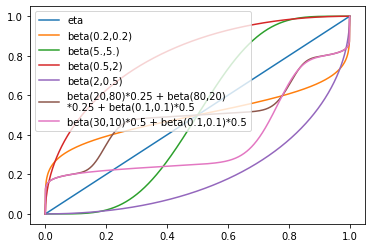

In [147]:
algos = ['Logistic Regression','Joint Logistic','Isotonic PostProcessing', 'Separate Ranking', 'Joint Ranking', 'Separate Slisotron', 'Joint Slisotron', 'PostProcessing']
annotators = [
             'eta' ,
             'beta(0.2,0.2)',
             'beta(5.,5.)',
            'beta(0.5,2)',
            'beta(2,0.5)',
            'beta(20,80)*0.25 + beta(80,20)\n*0.25 + beta(0.1,0.1)*0.5',
            'beta(30,10)*0.5 + beta(0.1,0.1)*0.5'
           ]
range01 = np.arange(0,1.001,0.001)
for j in range(num_annots):
    plt.plot(range01, distorts[j](range01))
    
plt.legend(annotators)

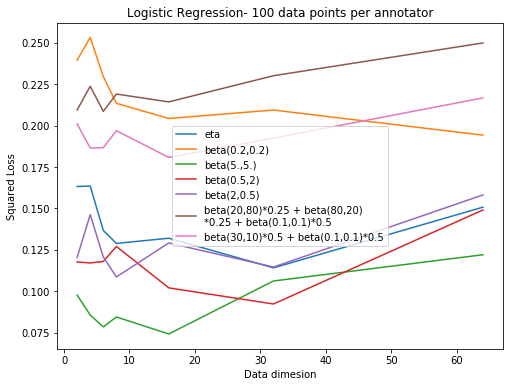

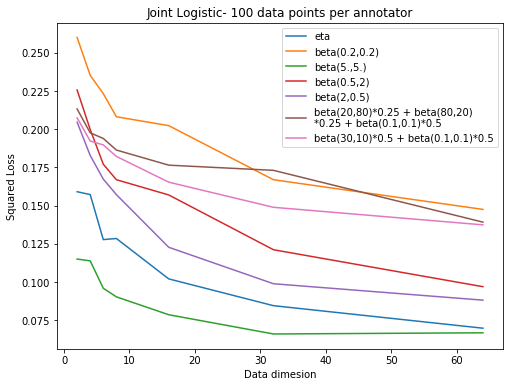

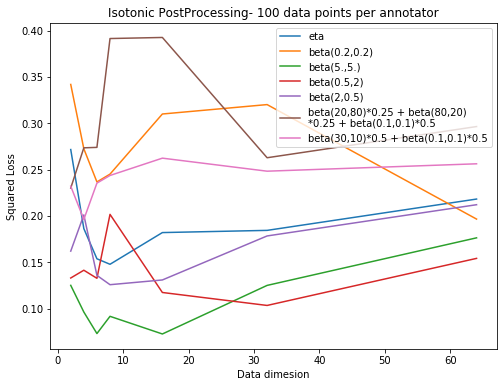

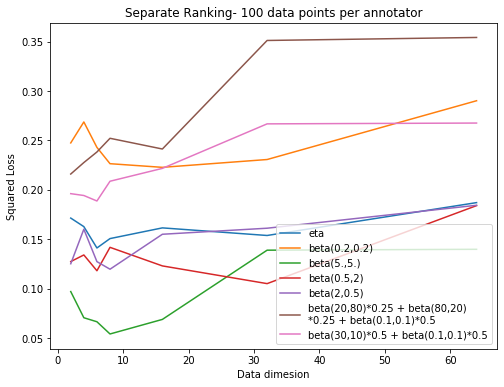

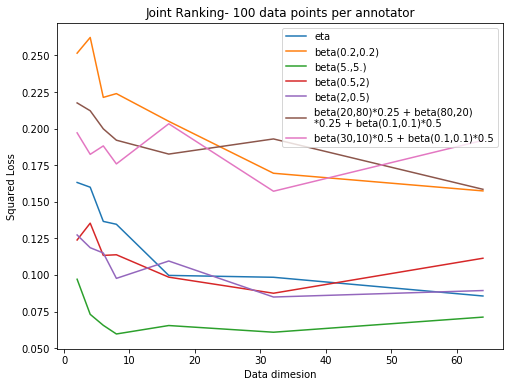

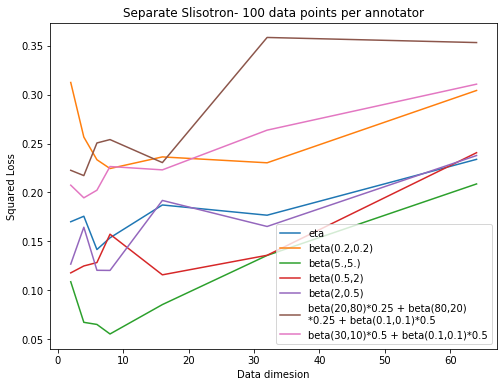

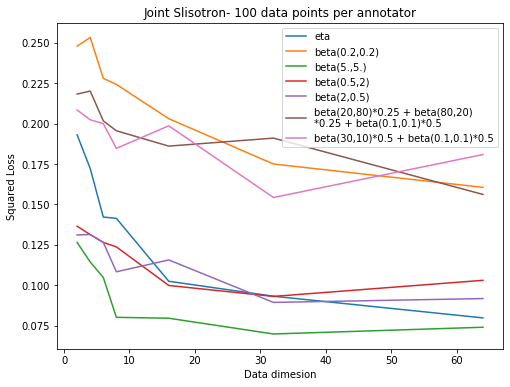

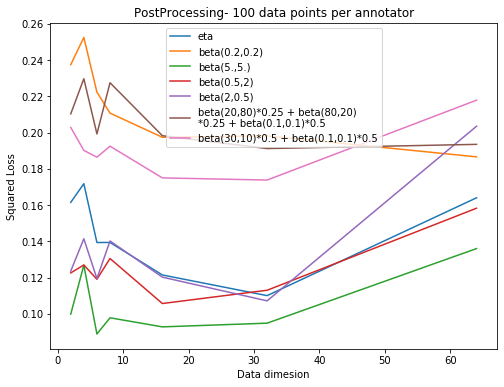

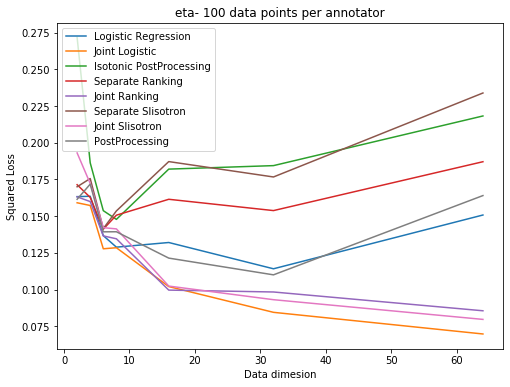

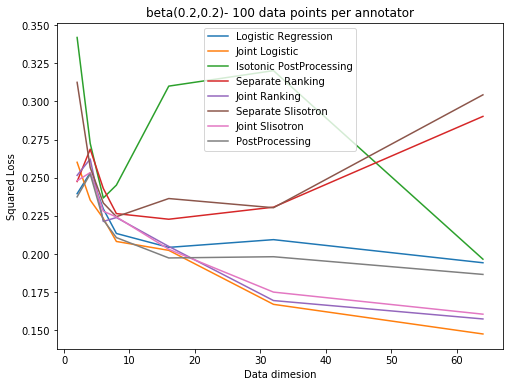

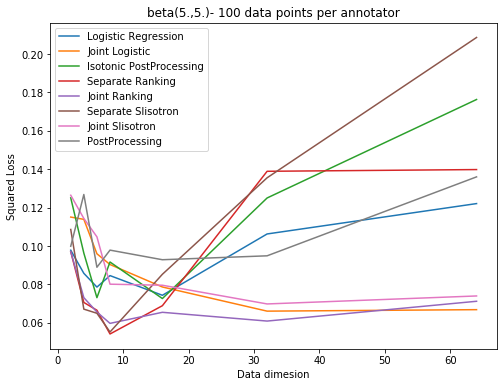

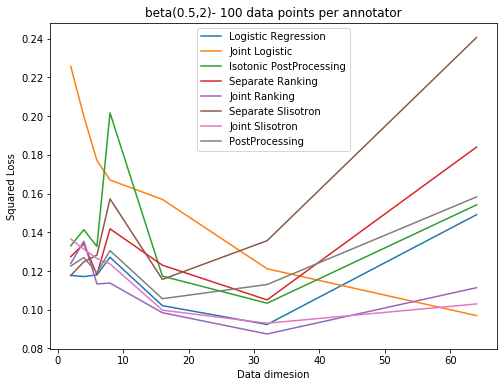

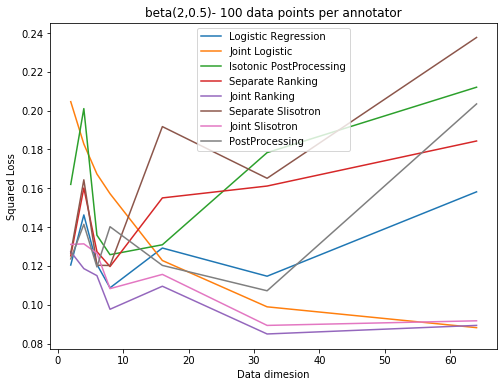

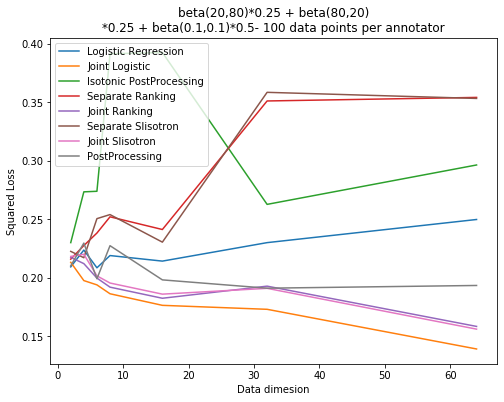

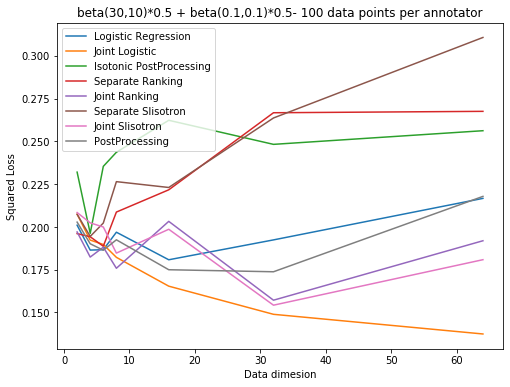

In [148]:
#For each algorithm plotting (loss vs dimensions) for various annotators
for i in range(num_algos):
    plt.subplots(nrows=1, ncols=1, figsize=(8,6))
    plt.title(algos[i] + '- 100 data points per annotator')
    plt.xlabel('Data dimesion')
    plt.ylabel('Squared Loss')
    for j in range(num_annots):
        plt.plot(np.array(dims), loss[i][:,j])
    plt.legend(annotators)
    plt.show()
    
#For each annotator plotting (loss vs dimensions) for various algorithms 
for i in range(num_annots):
    plt.subplots(nrows=1, ncols=1, figsize=(8,6))
    plt.title(annotators[i] + '- 100 data points per annotator')
    plt.xlabel('Data dimesion')
    plt.ylabel('Squared Loss')
    for j in range(num_algos):
        plt.plot(np.array(dims), loss[j][:,i])
    plt.legend(algos)
    plt.show()
    
#print(loss)

In [149]:
num_dp_per_annot = 100
num_test = 1000
data_dim = 4
X_train_d = []
Y_train_d = []
X_test_d = []
Y_test_d = []
X_valid_d = []
Y_valid_d = []
num_algos = 8
samples_list = [50,100,200,500,1000]
loss_data = np.zeros((num_algos, len(samples_list) ,num_annots))
data_count = 0
for num_dp_per_annot in samples_list:
    w_star = 2.*np.ones((data_dim))
    #print(w_star)
    np.random.seed(100)
    x_all_train = 2*np.random.rand(num_annots, num_dp_per_annot, data_dim)-1
    eta_all_train = 1./(1+np.exp(-np.dot(x_all_train,w_star)))
    y_all_train = 2*(np.random.rand(*eta_all_train.shape)<eta_all_train) - 1
    #print(x_all_train.shape)
    
    x_all_vali = 2*np.random.rand(num_annots, num_dp_per_annot//10, data_dim)-1
    eta_all_vali = 1./(1+np.exp(-np.dot(x_all_vali,w_star)))
    y_all_vali = 2*(np.random.rand(*eta_all_vali.shape)<eta_all_vali) - 1
    
    
    x_all_test = 2*np.random.rand(num_test, data_dim)-1
    eta_all_test = 1./(1+np.exp(-np.dot(x_all_test,w_star)))
    y_all_test = 2*(np.random.rand(*eta_all_test.shape)<eta_all_test) - 1

    #print(y_all_test)
    eta_tilde_all_train = np.array([distorts[i](eta_all_train[i]) for i in range(num_annots)])
    y_tilde_all_train = 2*(np.random.rand(*eta_tilde_all_train.shape)<eta_tilde_all_train) - 1
    
    eta_tilde_all_vali = np.array([distorts[i](eta_all_vali[i]) for i in range(num_annots)])
    y_tilde_all_vali = 2*(np.random.rand(*eta_tilde_all_vali.shape)<eta_tilde_all_vali) - 1

    eta_tilde_all_test = np.array([distorts[i](eta_all_test) for i in range(num_annots)])
    y_tilde_all_test = 2*(np.random.rand(*eta_tilde_all_test.shape)<eta_tilde_all_test) - 1
    #print(y_tilde_all_test.shape)

    j=0
#plt.scatter(x_all_train[j][:,0], x_all_train[j][:,1], c= y_all_train[j])

    #print(np.sum(y_all_train[j]==+1))
    X_train_d = x_all_train
    Y_train_d = y_tilde_all_train
    Y_train_d = (Y_train_d + 1)//2
    X_valid_d = x_all_vali
    Y_valid_d = y_tilde_all_vali
    Y_valid_d = (Y_valid_d + 1)//2
    X_test_d = []
    for i in range(num_annots):
        X_test_d.append(x_all_test)
    X_test_d = np.array(X_test_d)
    Y_test_d = y_tilde_all_test
    Y_test_d = (Y_test_d + 1)//2
    loss_data[0][data_count] = logisticReg()
    loss_data[1][data_count] = jointLogisticReg()
    loss_data[2][data_count] = isotonicPostProcess()
    loss_data[3][data_count] = separateRanking()
    loss_data[4][data_count] = jointRanking()
    loss_data[5][data_count] = separateSlisotron()
    loss_data[6][data_count] = jointSlisotron()
    loss_data[7][data_count] = postProcess()
    data_count = data_count + 1

#loss[i][j][k] indicates loss for algorithm-i, dimension-j and annotator-k

#print(jr_loss)
#print(Y_train_d)
#print(Y_test_d)
#print(X_train_d[1])

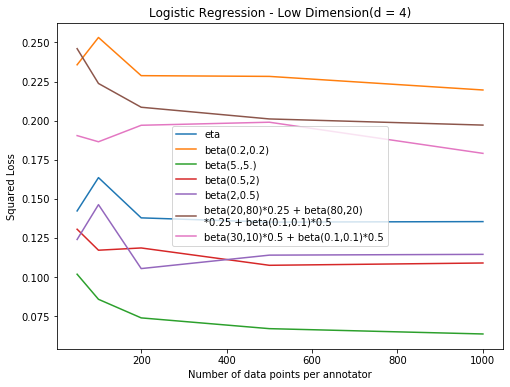

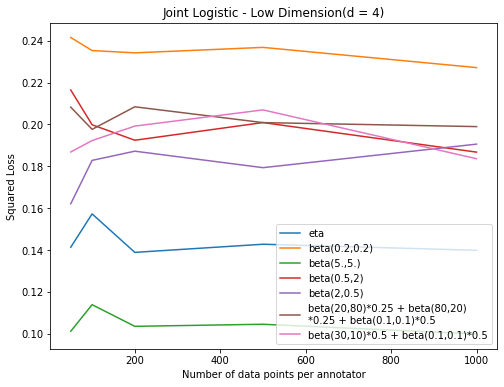

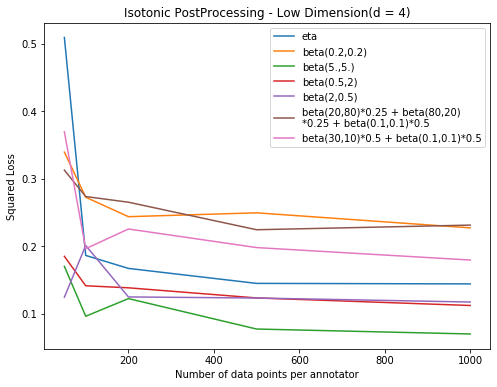

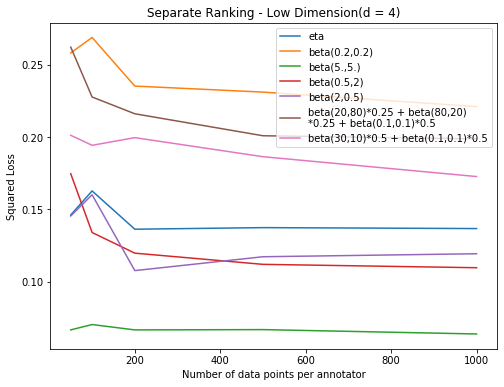

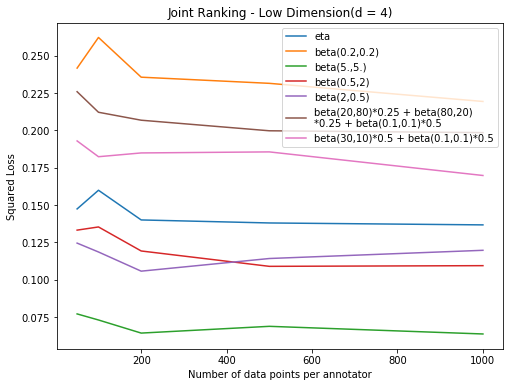

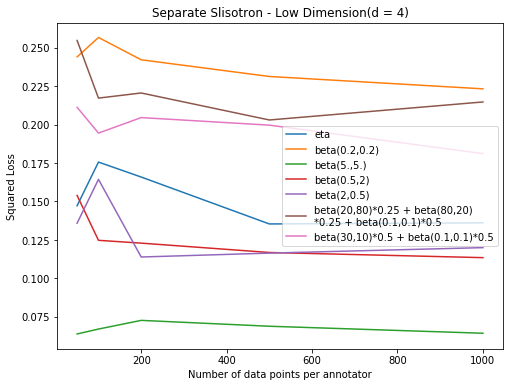

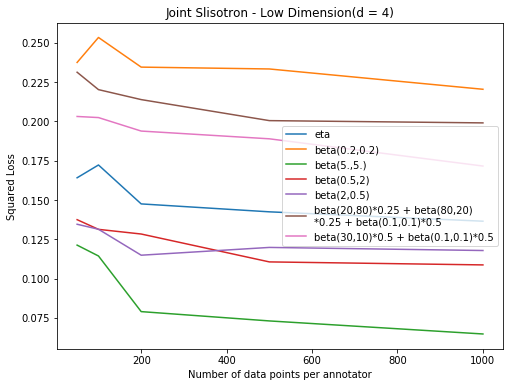

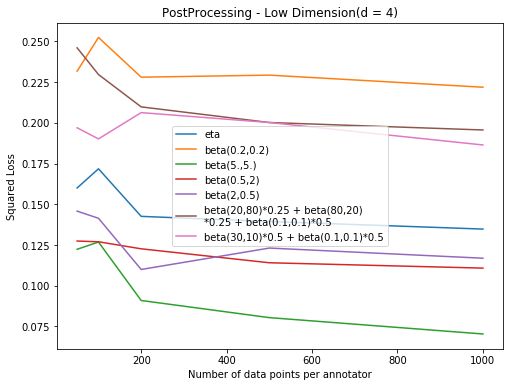

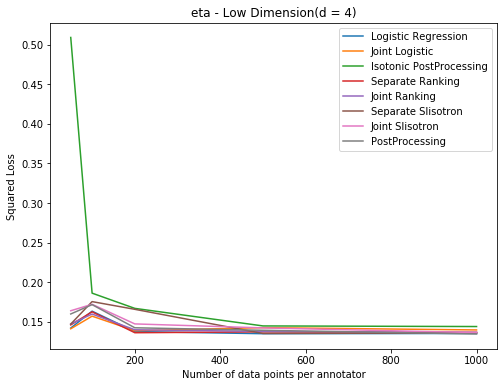

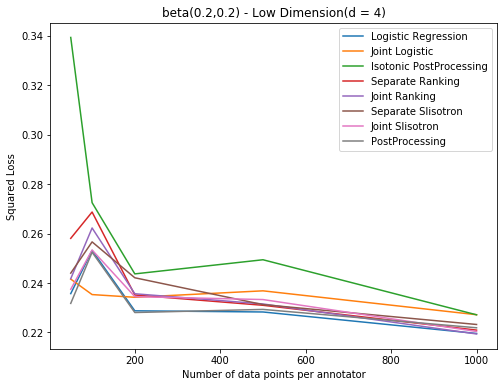

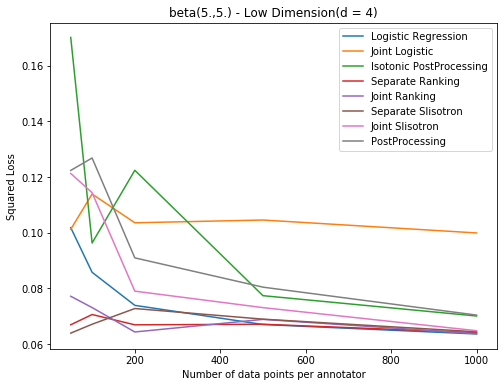

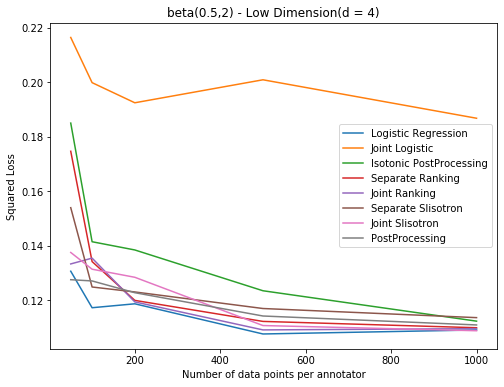

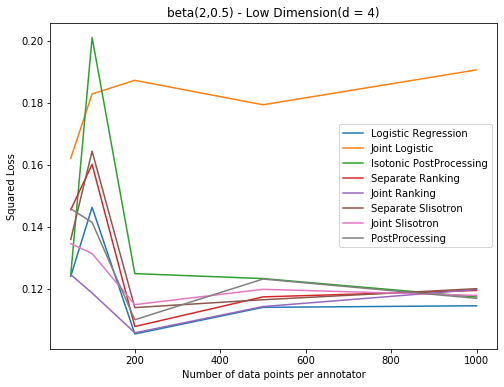

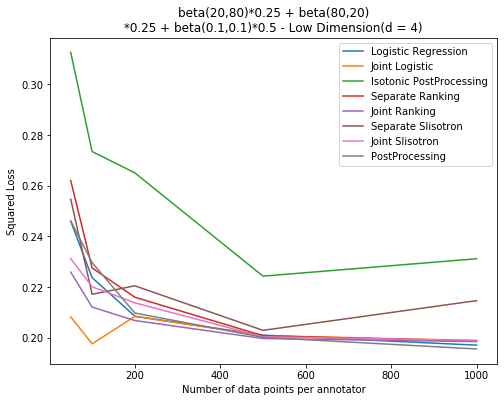

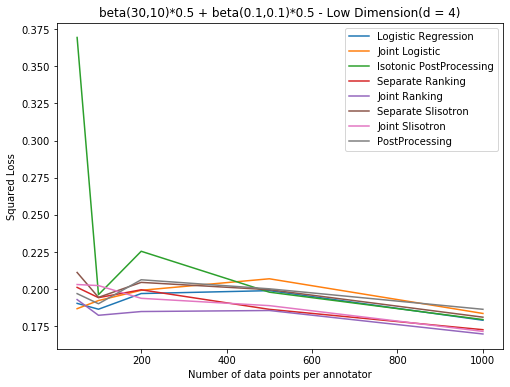

In [150]:
#loss_data[i][j][k] indicates loss for algorithm-i, data_points = samples_list[j] and annotator-k
#Use the above loss_data to make various
#For each algorithm plotting (loss vs data_points) for various annotators. Here dimension (d = 4)
for i in range(num_algos):
    plt.subplots(nrows=1, ncols=1, figsize=(8,6))
    plt.title(algos[i] + ' - Low Dimension(d = 4)')
    plt.xlabel("Number of data points per annotator")
    plt.ylabel("Squared Loss")
    for j in range(num_annots):
        plt.plot(np.array(samples_list), loss_data[i][:,j])
    plt.legend(annotators)
    plt.show()
    
#For each annotator plotting (loss vs data_points) for various algorithms. Here dimension (d = 4)
for i in range(num_annots):
    plt.subplots(nrows=1, ncols=1, figsize=(8,6))
    plt.title(annotators[i] + ' - Low Dimension(d = 4)')
    plt.xlabel("Number of data points per annotator")
    plt.ylabel("Squared Loss")
    for j in range(num_algos):
        plt.plot(np.array(samples_list), loss_data[j][:,i])
    plt.legend(algos)
    plt.show()

In [151]:
num_dp_per_annot = 100
num_test = 1000
data_dim = 64
X_train_d = []
Y_train_d = []
X_test_d = []
Y_test_d = []
X_valid_d = []
Y_valid_d = []
num_algos = 8
samples_list = [50,100,200,500,1000]
loss_data_high = np.zeros((num_algos, len(samples_list) ,num_annots))
data_count = 0
for num_dp_per_annot in samples_list:
    w_star = 2.*np.ones((data_dim))
    #print(w_star)
    np.random.seed(100)
    x_all_train = 2*np.random.rand(num_annots, num_dp_per_annot, data_dim)-1
    eta_all_train = 1./(1+np.exp(-np.dot(x_all_train,w_star)))
    y_all_train = 2*(np.random.rand(*eta_all_train.shape)<eta_all_train) - 1
    #print(x_all_train.shape)
    
    x_all_vali = 2*np.random.rand(num_annots, num_dp_per_annot//10, data_dim)-1
    eta_all_vali = 1./(1+np.exp(-np.dot(x_all_vali,w_star)))
    y_all_vali = 2*(np.random.rand(*eta_all_vali.shape)<eta_all_vali) - 1
    
    
    x_all_test = 2*np.random.rand(num_test, data_dim)-1
    eta_all_test = 1./(1+np.exp(-np.dot(x_all_test,w_star)))
    y_all_test = 2*(np.random.rand(*eta_all_test.shape)<eta_all_test) - 1

    #print(y_all_test)
    eta_tilde_all_train = np.array([distorts[i](eta_all_train[i]) for i in range(num_annots)])
    y_tilde_all_train = 2*(np.random.rand(*eta_tilde_all_train.shape)<eta_tilde_all_train) - 1
    
    eta_tilde_all_vali = np.array([distorts[i](eta_all_vali[i]) for i in range(num_annots)])
    y_tilde_all_vali = 2*(np.random.rand(*eta_tilde_all_vali.shape)<eta_tilde_all_vali) - 1

    eta_tilde_all_test = np.array([distorts[i](eta_all_test) for i in range(num_annots)])
    y_tilde_all_test = 2*(np.random.rand(*eta_tilde_all_test.shape)<eta_tilde_all_test) - 1
    #print(y_tilde_all_test.shape)

    j=0
#plt.scatter(x_all_train[j][:,0], x_all_train[j][:,1], c= y_all_train[j])

    #print(np.sum(y_all_train[j]==+1))
    X_train_d = x_all_train
    Y_train_d = y_tilde_all_train
    Y_train_d = (Y_train_d + 1)//2
    X_valid_d = x_all_vali
    Y_valid_d = y_tilde_all_vali
    Y_valid_d = (Y_valid_d + 1)//2
    X_test_d = []
    for i in range(num_annots):
        X_test_d.append(x_all_test)
    X_test_d = np.array(X_test_d)
    Y_test_d = y_tilde_all_test
    Y_test_d = (Y_test_d + 1)//2
    loss_data_high[0][data_count] = logisticReg()
    loss_data_high[1][data_count] = jointLogisticReg()
    loss_data_high[2][data_count] = isotonicPostProcess()
    loss_data_high[3][data_count] = separateRanking()
    loss_data_high[4][data_count] = jointRanking()
    loss_data_high[5][data_count] = separateSlisotron()
    loss_data_high[6][data_count] = jointSlisotron()
    loss_data_high[7][data_count] = postProcess()
    data_count = data_count + 1



#print(jr_loss)
#print(Y_train_d)
#print(Y_test_d)
#print(X_train_d[1])

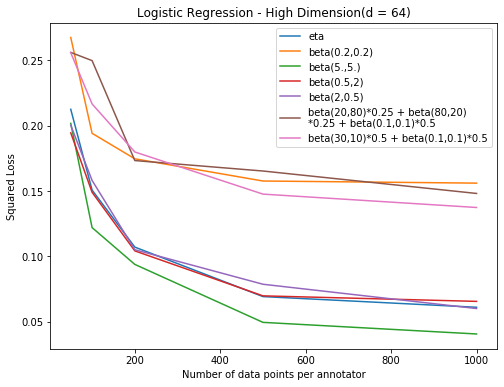

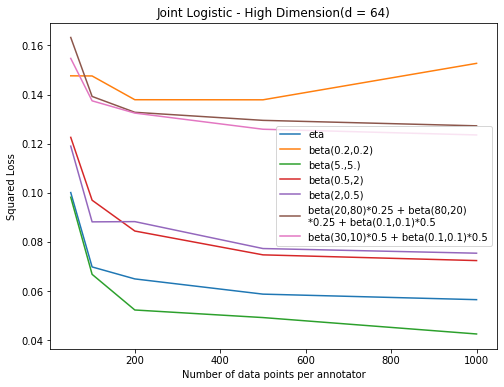

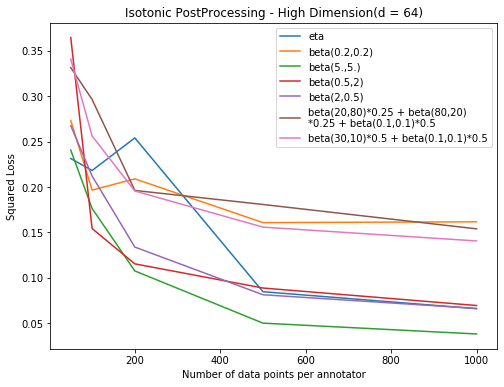

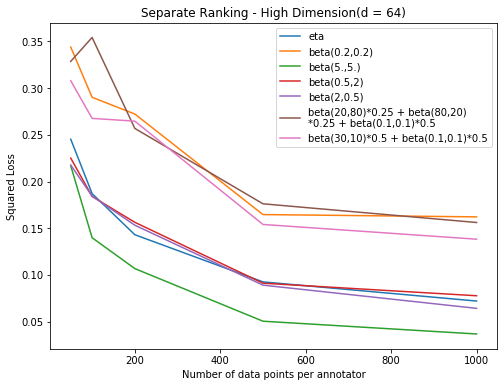

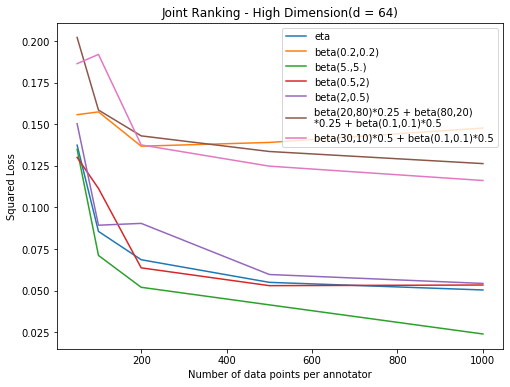

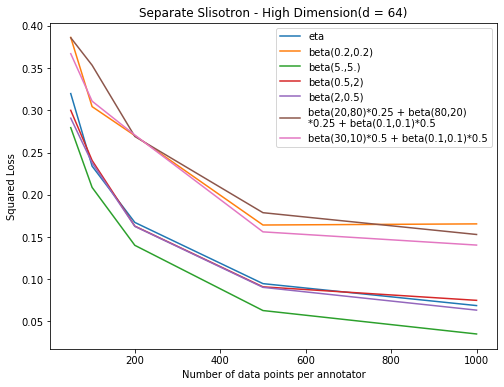

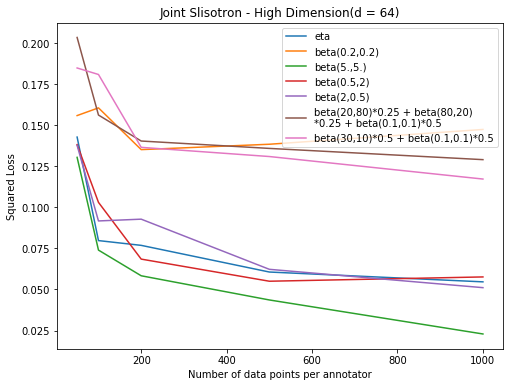

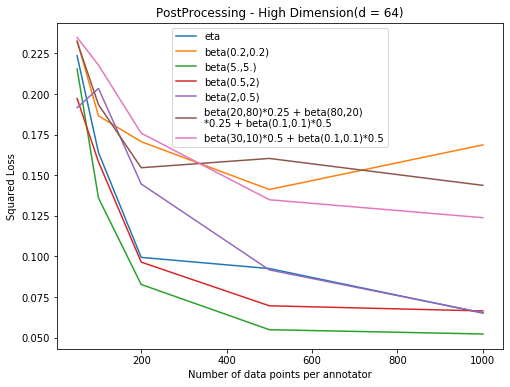

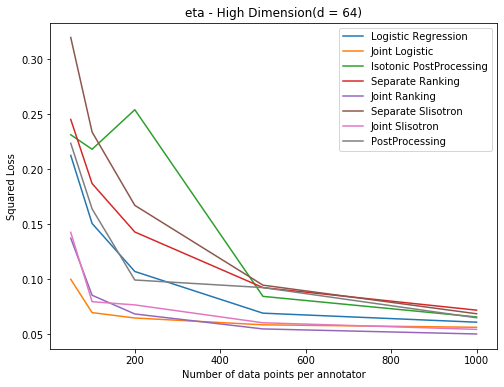

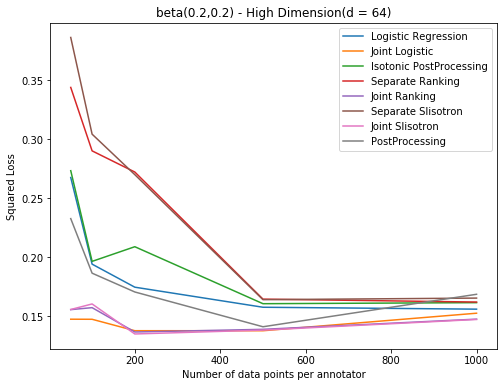

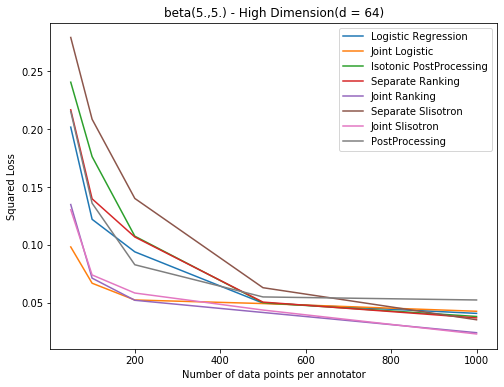

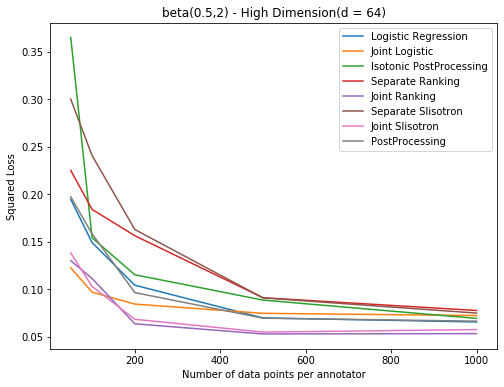

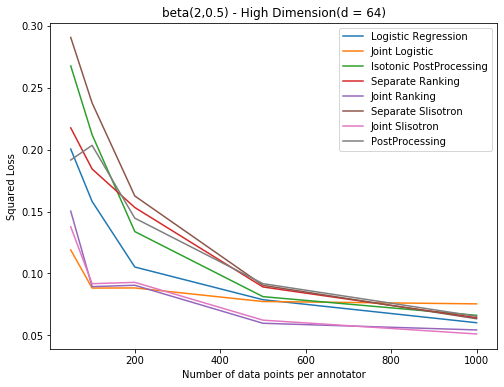

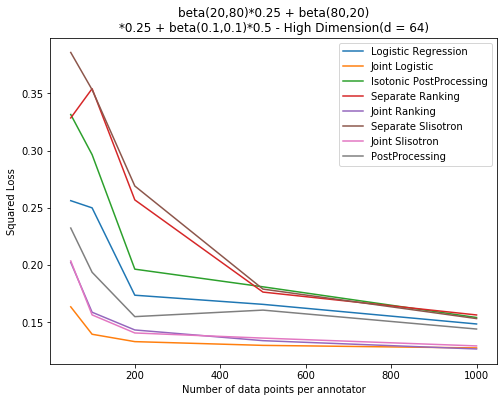

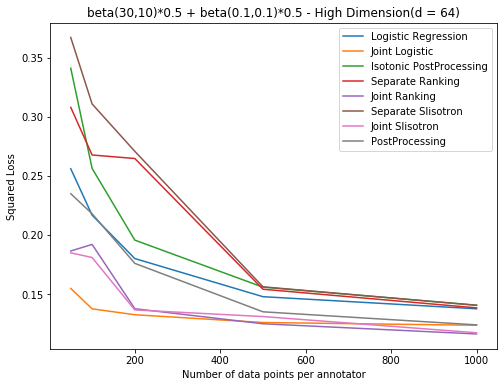

In [152]:
#loss_data[i][j][k] indicates loss for algorithm-i, data_points = samples_list[j] and annotator-k
#Use the above loss_data to make various

#For each algorithm plotting (loss vs data_points) for various annotators . Here dimension(d = 64)
for i in range(num_algos):
    plt.subplots(nrows=1, ncols=1, figsize=(8,6))
    plt.title(algos[i] + ' - High Dimension(d = 64)')
    plt.xlabel("Number of data points per annotator")
    plt.ylabel("Squared Loss")
    for j in range(num_annots):
        plt.plot(np.array(samples_list), loss_data_high[i][:,j])
    plt.legend(annotators)
    plt.show()
    
#For each annotator plotting (loss vs data_points) for various algorithms. Here dimension(d = 64)    
for i in range(num_annots):
    plt.subplots(nrows=1, ncols=1, figsize=(8,6))
    plt.title(annotators[i] + ' - High Dimension(d = 64)')
    plt.xlabel("Number of data points per annotator")
    plt.ylabel("Squared Loss")
    for j in range(num_algos):
        plt.plot(np.array(samples_list), loss_data_high[j][:,i])
    plt.legend(algos)
    plt.show()